# Importing Libraries

In [47]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize

col_pal = sns.color_palette()

# Inputting data, visualization and normalization

In [48]:
df = pd.read_csv('https://raw.githubusercontent.com/hemanthhariharan/CS_229_Project/main/T1.csv')

df # Raw df

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)   
0      01 01 2018 00:00           380.047791          5.311336  \
1      01 01 2018 00:10           453.769196          5.672167   
2      01 01 2018 00:20           306.376587          5.216037   
3      01 01 2018 00:30           419.645905          5.659674   
4      01 01 2018 00:40           380.650696          5.577941   
...                 ...                  ...               ...   
50525  31 12 2018 23:10          2963.980957         11.404030   
50526  31 12 2018 23:20          1684.353027          7.332648   
50527  31 12 2018 23:30          2201.106934          8.435358   
50528  31 12 2018 23:40          2515.694092          9.421366   
50529  31 12 2018 23:50          2820.466064          9.979332   

       Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                         416.328908          259.994904  
1                         519.917511          268.641113  
2                         390.900016          272.564789  
3                         516.127569          271.258087  
4                         491.702972          265.674286  
...                              ...                 ...  
50525                    3397.190793           80.502724  
50526                    1173.055771           84.062599  
50527                    1788.284755           84.742500  
50528                    2418.382503           84.297913  
50529                    2779.184096           82.274620  

[50530 rows x 5 columns]

In [49]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format = "%d %m %Y %H:%M", errors = "coerce")

df = df.set_index('Date/Time')

# Creating time-series features

df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_of_week

df

LV ActivePower (kW)  Wind Speed (m/s)   
Date/Time                                                    
2018-01-01 00:00:00           380.047791          5.311336  \
2018-01-01 00:10:00           453.769196          5.672167   
2018-01-01 00:20:00           306.376587          5.216037   
2018-01-01 00:30:00           419.645905          5.659674   
2018-01-01 00:40:00           380.650696          5.577941   
...                                  ...               ...   
2018-12-31 23:10:00          2963.980957         11.404030   
2018-12-31 23:20:00          1684.353027          7.332648   
2018-12-31 23:30:00          2201.106934          8.435358   
2018-12-31 23:40:00          2515.694092          9.421366   
2018-12-31 23:50:00          2820.466064          9.979332   

                     Theoretical_Power_Curve (KWh)  Wind Direction (°)  hour   
Date/Time                                                                      
2018-01-01 00:00:00                     416.328908          259.994904     0  \
2018-01-01 00:10:00                     519.917511          268.641113     0   
2018-01-01 00:20:00                     390.900016          272.564789     0   
2018-01-01 00:30:00                     516.127569          271.258087     0   
2018-01-01 00:40:00                     491.702972          265.674286     0   
...                                            ...                 ...   ...   
2018-12-31 23:10:00                    3397.190793           80.502724    23   
2018-12-31 23:20:00                    1173.055771           84.062599    23   
2018-12-31 23:30:00                    1788.284755           84.742500    23   
2018-12-31 23:40:00                    2418.382503           84.297913    23   
2018-12-31 23:50:00                    2779.184096           82.274620    23   

                     day_of_week  
Date/Time                         
2018-01-01 00:00:00            0  
2018-01-01 00:10:00            0  
2018-01-01 00:20:00            0  
2018-01-01 00:30:00            0  
2018-01-01 00:40:00            0  
...                          ...  
2018-12-31 23:10:00            0  
2018-12-31 23:20:00            0  
2018-12-31 23:30:00            0  
2018-12-31 23:40:00            0  
2018-12-31 23:50:00            0  

[50530 rows x 6 columns]

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50530 entries, 2018-01-01 00:00:00 to 2018-12-31 23:50:00
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   LV ActivePower (kW)            50530 non-null  float64
 1   Wind Speed (m/s)               50530 non-null  float64
 2   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 3   Wind Direction (°)             50530 non-null  float64
 4   hour                           50530 non-null  int32  
 5   day_of_week                    50530 non-null  int32  
dtypes: float64(4), int32(2)
memory usage: 2.3 MB


In [51]:
df.describe()

LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)   
count         50530.000000      50530.000000                   50530.000000  \
mean           1307.684332          7.557952                    1492.175463   
std            1312.459242          4.227166                    1368.018238   
min              -2.471405          0.000000                       0.000000   
25%              50.677890          4.201395                     161.328167   
50%             825.838074          7.104594                    1063.776283   
75%            2482.507568         10.300020                    2964.972462   
max            3618.732910         25.206011                    3600.000000   

       Wind Direction (°)          hour   day_of_week  
count        50530.000000  50530.000000  50530.000000  
mean           123.687559     11.517356      2.998377  
std             93.443736      6.934626      1.986934  
min              0.000000      0.000000      0.000000  
25%             49.315437      5.000000      1.000000  
50%             73.712978     12.000000      3.000000  
75%            201.696720     18.000000      5.000000  
max            359.997589     23.000000      6.000000

In [52]:
# Normalize df

df_normalized = (df - df.mean())/ df.std()

mean_target = df['Theoretical_Power_Curve (KWh)'].mean()

std_target = df['Theoretical_Power_Curve (KWh)'].std()

In [53]:
corr = df_normalized.corr() 

sns.heatmap(corr, annot=True)

# plt.savefig("correlation.jpg")

<Axes: >

In [54]:
sns.boxplot(data=df, x='hour', y='Wind Speed (m/s)')
plt.title('Wind speed by hour')

Text(0.5, 1.0, 'Wind speed by hour')

Text(0.5, 1.0, 'KWh by hour')

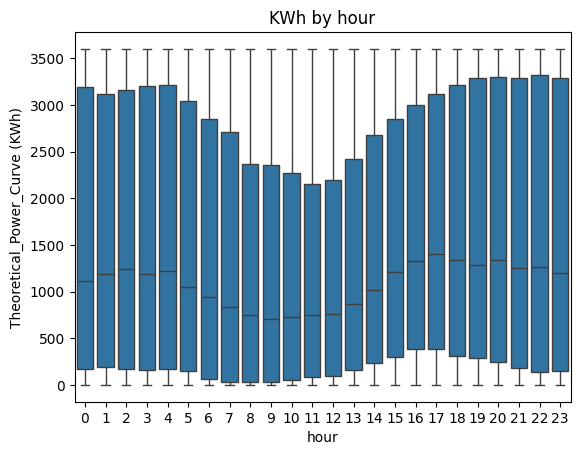

In [55]:
sns.boxplot(data=df, x='hour', y='Theoretical_Power_Curve (KWh)')
plt.title('KWh by hour')
# plt.savefig("kWh_by_hour.jpg")

Text(0.5, 1.0, 'KWh by day of week')

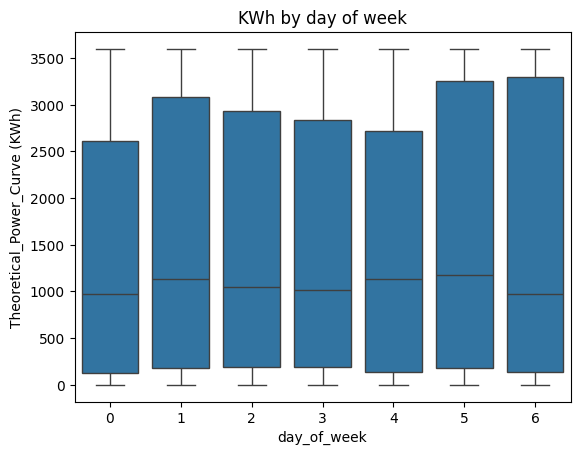

In [56]:
sns.boxplot(data=df, x='day_of_week', y='Theoretical_Power_Curve (KWh)')
plt.title('KWh by day of week')

Text(0.5, 1.0, 'Wind Speed (m/s) by day of week')

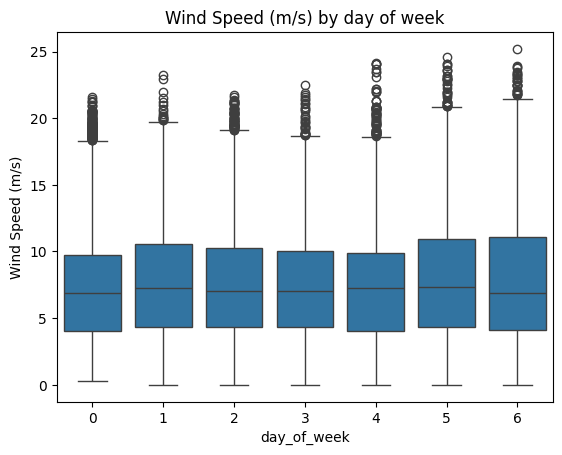

In [57]:
sns.boxplot(data=df, x='day_of_week', y='Wind Speed (m/s)')
plt.title('Wind Speed (m/s) by day of week')

# Train_test splitting

In [58]:
# Train_test split

train = df_normalized.loc[df.index < '2018-12-01'] # train on 11 months
test = df_normalized.loc[df.index >= '2018-12-01'] # test on 1 month

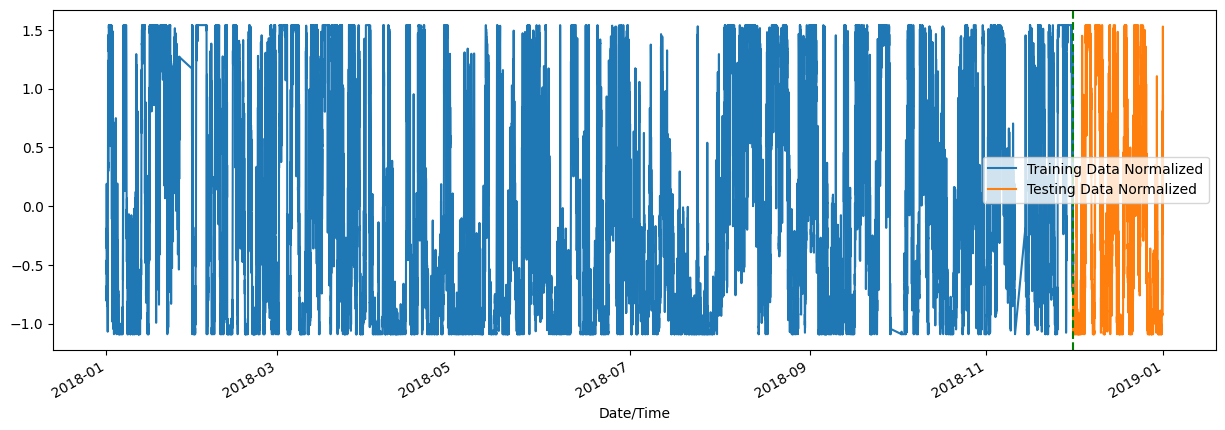

In [59]:
fig, ax = plt.subplots(figsize=(15, 5))
train['Theoretical_Power_Curve (KWh)'].plot(ax=ax, label='Training Data Normalized')
test['Theoretical_Power_Curve (KWh)'].plot(ax=ax, label='Testing Data Normalized')
ax.axvline('2018-12-01', color='green', ls='--')
plt.legend()
plt.show()

Text(0, 0.5, 'Theoretical_Power_Curve (KWh)')

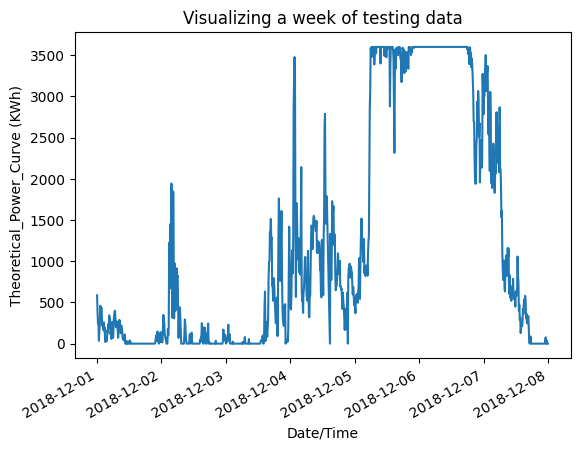

In [60]:
# Just visualizing one week of data

df.loc[(df.index > '2018-12-01') & (df.index <= '2018-12-08')]['Theoretical_Power_Curve (KWh)'].plot()
plt.title('Visualizing a week of testing data')
plt.ylabel('Theoretical_Power_Curve (KWh)')

# XG Boost Training

In [61]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=100, learning_rate=0.01, max_depth=5, reg_lambda=1)

features = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Wind Direction (°)', 'hour', 'day_of_week']
target = ['Theoretical_Power_Curve (KWh)']

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:0.98793	validation_1-rmse:1.01131
[100]	validation_0-rmse:0.36199	validation_1-rmse:0.37057
[200]	validation_0-rmse:0.13268	validation_1-rmse:0.13581
[300]	validation_0-rmse:0.04875	validation_1-rmse:0.04987
[400]	validation_0-rmse:0.01823	validation_1-rmse:0.01858
[500]	validation_0-rmse:0.00761	validation_1-rmse:0.00761
[600]	validation_0-rmse:0.00459	validation_1-rmse:0.00442
[700]	validation_0-rmse:0.00400	validation_1-rmse:0.00381
[800]	validation_0-rmse:0.00390	validation_1-rmse:0.00372
[900]	validation_0-rmse:0.00388	validation_1-rmse:0.00371
[999]	validation_0-rmse:0.00386	validation_1-rmse:0.00371


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [62]:
train_rmse = reg.evals_result()["validation_0"]["rmse"]
eval_rmse = reg.evals_result()["validation_1"]["rmse"]

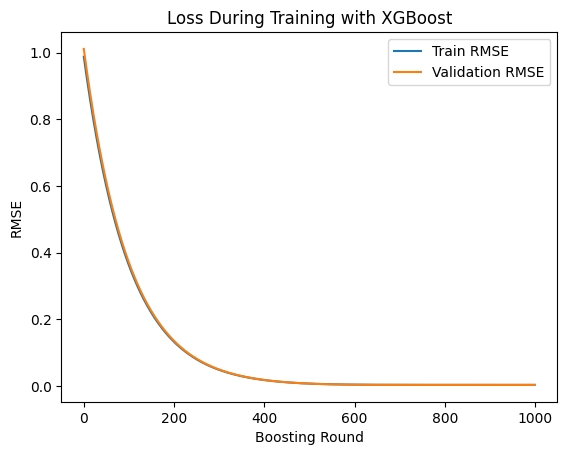

In [63]:
plt.plot(train_rmse, label="Train RMSE")
plt.plot(eval_rmse, label="Validation RMSE")
plt.title("Loss During Training with XGBoost")
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.legend()

# plt.savefig("Loss during training.jpg")

In [64]:
y_pred = reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

rmse

0.003711888268061442

In [65]:
reg.feature_importances_

array([1.1443855e-06, 9.9999595e-01, 9.7402540e-07, 9.3432152e-07,
       1.0444720e-06], dtype=float32)

# Testing

In [66]:
# Forecast on test set

test['prediction'] = reg.predict(X_test)

/var/folders/jl/h42wvdfj3pvc7s68tr4ybg5c0000gn/T/ipykernel_38992/3646081960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


In [67]:
df_merged = pd.merge(df, test[['prediction']], left_index=True, right_index=True)

df_merged['prediction'] = df_merged['prediction'] * std_target + mean_target

df_merged

LV ActivePower (kW)  Wind Speed (m/s)   
Date/Time                                                    
2018-12-01 00:00:00            57.407021          6.166973  \
2018-12-01 00:10:00            27.440510          5.884330   
2018-12-01 00:20:00             0.364866          5.168109   
2018-12-01 00:30:00             0.000000          4.607421   
2018-12-01 00:40:00             0.000000          4.713554   
...                                  ...               ...   
2018-12-31 23:10:00          2963.980957         11.404030   
2018-12-31 23:20:00          1684.353027          7.332648   
2018-12-31 23:30:00          2201.106934          8.435358   
2018-12-31 23:40:00          2515.694092          9.421366   
2018-12-31 23:50:00          2820.466064          9.979332   

                     Theoretical_Power_Curve (KWh)  Wind Direction (°)  hour   
Date/Time                                                                      
2018-12-01 00:00:00                     681.780444           47.659679     0  \
2018-12-01 00:10:00                     586.656800           49.751839     0   
2018-12-01 00:20:00                     378.397651           54.350288     0   
2018-12-01 00:30:00                     245.089872           53.266201     0   
2018-12-01 00:40:00                     268.621965           51.365490     0   
...                                            ...                 ...   ...   
2018-12-31 23:10:00                    3397.190793           80.502724    23   
2018-12-31 23:20:00                    1173.055771           84.062599    23   
2018-12-31 23:30:00                    1788.284755           84.742500    23   
2018-12-31 23:40:00                    2418.382503           84.297913    23   
2018-12-31 23:50:00                    2779.184096           82.274620    23   

                     day_of_week   prediction  
Date/Time                                      
2018-12-01 00:00:00            5   677.064026  
2018-12-01 00:10:00            5   591.343384  
2018-12-01 00:20:00            5   372.798584  
2018-12-01 00:30:00            5   247.386597  
2018-12-01 00:40:00            5   271.149048  
...                          ...          ...  
2018-12-31 23:10:00            0  3395.697266  
2018-12-31 23:20:00            0  1170.968262  
2018-12-31 23:30:00            0  1794.916870  
2018-12-31 23:40:00            0  2399.950439  
2018-12-31 23:50:00            0  2775.960205  

[4447 rows x 7 columns]

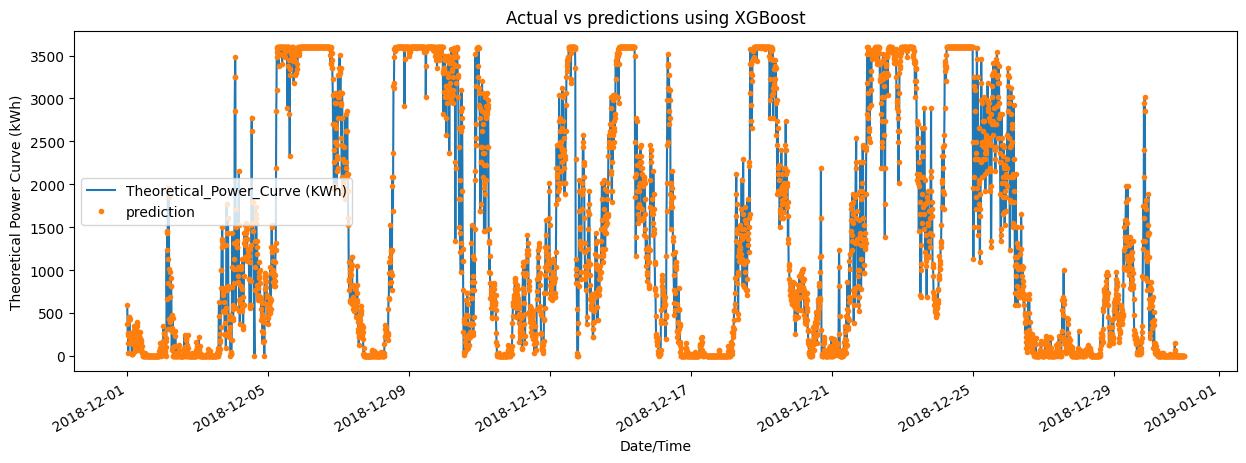

In [68]:
# Predictions

fig, ax = plt.subplots(figsize=(15, 5))
ax = df_merged[['Theoretical_Power_Curve (KWh)']].loc[(df_merged.index > '2018-12-01') & (df_merged.index <= '2018-12-31')].plot(ax=ax)
df_merged[['prediction']].loc[(df_merged.index > '2018-12-01') & (df_merged.index <= '2018-12-31')].plot(ax=ax, style='.')
plt.title('Actual vs predictions using XGBoost')
plt.ylabel('Theoretical Power Curve (kWh)')
plt.show()

# Walk Forward Validation

In [69]:
n = len(df_normalized)
folds = 10
rows_per_fold = int(n / 10)

for k in range(folds - 1):
    train_walk = df_normalized[k * rows_per_fold:(k + 1) * rows_per_fold]
    test_walk = df_normalized[(k + 1) * rows_per_fold:(k + 2) * rows_per_fold]
    X_train_walk = train_walk[features]
    y_train_walk = train_walk[target]

    X_test_walk = test_walk[features]
    y_test_walk = test_walk[target]

    reg.fit(X_train_walk, y_train_walk, eval_set=[(X_train_walk, y_train_walk), (X_test_walk, y_test_walk)], verbose=100)
    

[0]	validation_0-rmse:1.02952	validation_1-rmse:1.06784
[100]	validation_0-rmse:0.37814	validation_1-rmse:0.39221
[200]	validation_0-rmse:0.13895	validation_1-rmse:0.14415
[300]	validation_0-rmse:0.05119	validation_1-rmse:0.05311
[400]	validation_0-rmse:0.01920	validation_1-rmse:0.01991
[500]	validation_0-rmse:0.00801	validation_1-rmse:0.00838
[600]	validation_0-rmse:0.00472	validation_1-rmse:0.00515
[700]	validation_0-rmse:0.00400	validation_1-rmse:0.00455
[800]	validation_0-rmse:0.00381	validation_1-rmse:0.00447
[900]	validation_0-rmse:0.00373	validation_1-rmse:0.00447
[987]	validation_0-rmse:0.00369	validation_1-rmse:0.00447
[0]	validation_0-rmse:1.04555	validation_1-rmse:1.08612
[100]	validation_0-rmse:0.38395	validation_1-rmse:0.39884
[200]	validation_0-rmse:0.14105	validation_1-rmse:0.14643
[300]	validation_0-rmse:0.05195	validation_1-rmse:0.05385
[400]	validation_0-rmse:0.01949	validation_1-rmse:0.02011
[500]	validation_0-rmse:0.00814	validation_1-rmse:0.00828
[600]	validation_0